In [1]:
!pip install huggingface-hub --quiet


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
!pip install -U transformers bitsandbytes einops accelerate peft scipy datasets matplotlib --quiet


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
# set seed for reproducibility
from transformers import set_seed
set_seed(42)

In [4]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

# Load model
modelpath = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(
    modelpath,
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_quant_type="nf4",
    ),
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
)

config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/2.03k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- configuration_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi.py:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- modeling_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/577M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(modelpath, use_fast=False)

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
# Add tokens <|im_start|> and <|im_end|>, latter is special eos token,
tokenizer.add_tokens(["<|im_start|>", "<PAD>"])
tokenizer.pad_token = "<PAD>"
tokenizer.add_special_tokens(dict(eos_token="<|im_end|>"))
model.resize_token_embeddings(
    new_num_tokens=len(tokenizer),
    pad_to_multiple_of=64)   # phi2 default is 64, see configuration_phi.py
model.config.eos_token_id = tokenizer.eos_token_id

In [7]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules = ['Wqkv','out_proj'],
    lora_dropout=0.1,
    bias="none",
    modules_to_save = ["lm_head", "embed_tokens"],
    task_type="CAUSAL_LM"
)

# Add adapters to model
model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=False)
model = get_peft_model(model, lora_config)
model.config.use_cache = False

In [8]:
from datasets import load_dataset

dataset = load_dataset("WasamiKirua/Samatha-Phi2-ENG")
dataset = dataset["train"].train_test_split(test_size=0.1)

Generating train split:   0%|          | 0/6534 [00:00<?, ? examples/s]

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'conversations'],
        num_rows: 5880
    })
    test: Dataset({
        features: ['id', 'conversations'],
        num_rows: 654
    })
})

In [10]:
dataset['train'][0]

{'id': '3984',
 'conversations': ['Hi! Can you help me understand conditional statements in programming, like if-else structures?',
  'Hello! I\'d be glad to help. Conditional statements are used to make decisions in code based on whether a specific condition is met. They help control the flow of a program. In most programming languages, you\'ll find the basic "if-else" structure. Here\'s a quick explanation:\n\nThe "if" statement is used when you want to check if a certain condition is true. If the condition is true, the code within the "if" block will be executed. If the condition is false, the code within the "else" block is executed (if an "else" block is present). You can also use "elif" (else-if) to test multiple conditions in sequence. In Python, for example, an if-else structure looks like this:\n\n```python\nif condition1:\n    # Block of code to be executed if condition1 is true\nelif condition2:\n    # Block of code to be executed if condition1 is false and condition2 is tru

In [11]:
import os
from functools import partial

# Format (chatML) and tokenize dataset
templates=[
    "<|im_start|>assistant\n{msg}<|im_end|>",
    "<|im_start|>user\n{msg}<|im_end|>"
]
IGNORE_INDEX=-100

def tokenize(input, max_length):
    input_ids, attention_mask, labels = [], [], []

    for i,msg in enumerate(input["conversations"]):
        isHuman = i%2==0
        msg_chatml=templates[isHuman].format(msg=msg)
        msg_tokenized=tokenizer(msg_chatml, truncation=False, add_special_tokens=False)

        input_ids+=msg_tokenized["input_ids"]
        attention_mask+=msg_tokenized["attention_mask"]
        labels+=[IGNORE_INDEX]*len(msg_tokenized["input_ids"]) if isHuman else msg_tokenized["input_ids"]

    return {
        "input_ids": input_ids[:max_length],
        "attention_mask": attention_mask[:max_length],
        "labels": labels[:max_length],
    }

dataset_tokenized = dataset.map(
    partial(tokenize, max_length=1024),
    batched=False,
    num_proc=os.cpu_count(),    # multithreaded
    remove_columns=dataset["train"].column_names  # don't need this anymore, we have tokens from here on
)

Map (num_proc=20):   0%|          | 0/5880 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/654 [00:00<?, ? examples/s]

longest sample: 1024 tokens


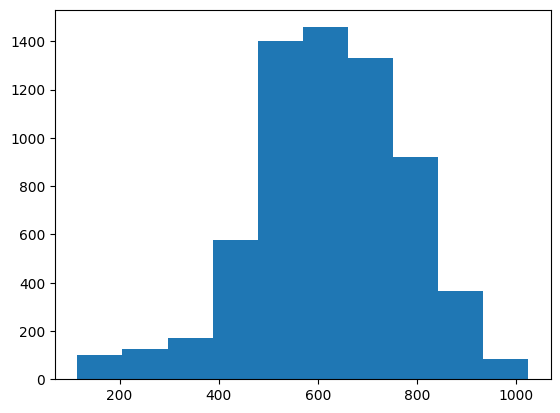

In [12]:
# Sample size distribution
import matplotlib.pyplot as plt

data = [len(tok) for tok in (dataset_tokenized["train"]["input_ids"]+dataset_tokenized["test"]["input_ids"])]
print(f"longest sample: {max(data)} tokens")

plt.hist(data, bins=10)
plt.show()

In [13]:
# collate function - to transform list of dictionaries [ {input_ids: [123, ..]}, {.. ] to single batch dictionary { input_ids: [..], labels: [..], attention_mask: [..] }
def collate(elements):
    tokens=[e["input_ids"] for e in elements]
    tokens_maxlen=max([len(t) for t in tokens])

    for i,sample in enumerate(elements):
        input_ids=sample["input_ids"]
        labels=sample["labels"]
        attention_mask=sample["attention_mask"]

        pad_len=tokens_maxlen-len(input_ids)

        input_ids.extend( pad_len * [tokenizer.pad_token_id] )
        labels.extend( pad_len * [IGNORE_INDEX] )
        attention_mask.extend( pad_len * [0] )

    batch={
        "input_ids": torch.tensor( [e["input_ids"] for e in elements] ),
        "labels": torch.tensor( [e["labels"] for e in elements] ),
        "attention_mask": torch.tensor( [e["attention_mask"] for e in elements] ),
    }

    return batch

In [16]:
from transformers import TrainingArguments, Trainer

bs=1     # batch size
ga_steps=16  # gradient acc. steps
epochs=5
lr=0.00002

steps_per_epoch=len(dataset_tokenized["train"])//(bs*ga_steps)

args = TrainingArguments(
    output_dir="out",
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=16,
    evaluation_strategy="steps",
    logging_steps=1,
    eval_steps=steps_per_epoch//2,
    save_steps=steps_per_epoch,
    gradient_accumulation_steps=ga_steps,
    num_train_epochs=epochs,
    lr_scheduler_type="constant",
    optim="paged_adamw_32bit",      # val_loss will go nan with paged_adamw_8bit
    learning_rate=lr,
    group_by_length=False,
    bf16=True,
    ddp_find_unused_parameters=False,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=collate,
    train_dataset=dataset_tokenized["train"],
    eval_dataset=dataset_tokenized["test"],
)

In [17]:
trainer.train()

Step,Training Loss,Validation Loss
183,1.248700,1.237849
366,1.280100,1.205218
549,1.192400,1.189266
732,1.106600,1.178379
915,1.184200,1.171010
1098,1.185600,1.164833
1281,1.122900,1.162227
1464,1.127600,1.156326
1647,1.123500,1.155393
1830,0.995800,1.152818


TrainOutput(global_step=1835, training_loss=1.1746719654964166, metrics={'train_runtime': 13029.9912, 'train_samples_per_second': 2.256, 'train_steps_per_second': 0.141, 'total_flos': 3.0573392652926976e+17, 'train_loss': 1.1746719654964166, 'epoch': 4.99})

## Merge LoRa Adapters with Base Model

In [19]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import torch

# base model
base_path="microsoft/phi-2"  

# adapters: path to folder with adapter_model.safetensors
adapter_path="out/checkpoint-1835" 

# where to save merged model
save_to="merged/phi-2-Samantha-en-test"       

base_model = AutoModelForCausalLM.from_pretrained(
    base_path,
    return_dict=True,
    torch_dtype=torch.bfloat16,
    device_map="cpu",
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(base_path)

# Add/set tokens same tokens to base model before merging, like we did before starting training  
tokenizer.add_tokens(["<|im_start|>", "<PAD>"])
tokenizer.pad_token = "<PAD>"
tokenizer.add_special_tokens(dict(eos_token="<|im_end|>"))
base_model.resize_token_embeddings(
    new_num_tokens=len(tokenizer),
    pad_to_multiple_of=64)   # phi2 default is 64, see configuration_phi.py
base_model.config.eos_token_id = tokenizer.eos_token_id

# Load LoRA and merge
model = PeftModel.from_pretrained(base_model, adapter_path)
model = model.merge_and_unload()

model.save_pretrained(save_to, safe_serialization=True, max_shard_size='4GB')
tokenizer.save_pretrained(save_to)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


('merged/phi-2-Samantha-en-test/tokenizer_config.json',
 'merged/phi-2-Samantha-en-test/special_tokens_map.json',
 'merged/phi-2-Samantha-en-test/vocab.json',
 'merged/phi-2-Samantha-en-test/merges.txt',
 'merged/phi-2-Samantha-en-test/added_tokens.json',
 'merged/phi-2-Samantha-en-test/tokenizer.json')